In [1]:
library(tidyverse)
library(broom)
library(tableone)
library(ggplot2)
library(dplyr)
library(car)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'tableone' was built under R version 4.4.3"
Warning message:
"package 'car' was built under R version 4.4.3"
Loading required package: carData

Warning message:
"package 'carData' was built under R version 4.4.3"

Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


The following object is masked from 'package:purrr':

    some




In [2]:
data <- read_csv("data_donnees_2021_ind_v2.csv")

head(data)
dim(data)

Rows: 980868 Columns: 144
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (144): PPSORT, ABOID, AGEGRP, AGEIMM, ATTSCH, BFNMEMB, BedRm, CFInc, CFI...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


PPSORT,ABOID,AGEGRP,AGEIMM,ATTSCH,BFNMEMB,BedRm,CFInc,CFInc_AT,CFSTAT,⋯,WT7,WT8,WT9,WT10,WT11,WT12,WT13,WT14,WT15,WT16
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,6,13,7,1,0,4,30,27,2,⋯,22.90113,22.90113,22.90113,249.27876,22.90113,22.90113,22.90113,22.90113,22.90113,22.90113
2,6,11,5,1,0,3,18,18,2,⋯,22.89379,22.89379,22.89379,22.89379,22.89379,22.89379,22.89379,22.89379,22.89379,22.89379
3,1,13,99,1,0,0,7,7,6,⋯,22.90134,22.90134,22.90134,22.90134,22.90134,22.90134,22.90134,22.90134,22.90134,22.90134
4,6,16,99,1,0,4,15,15,2,⋯,22.87713,22.87713,22.87713,22.87713,22.87713,22.87713,22.87713,22.87713,22.87713,22.87713
5,6,18,99,1,0,3,13,13,3,⋯,22.90134,22.90134,22.90134,22.90134,22.90134,22.90134,22.90134,22.90134,22.90134,22.90134
6,2,16,99,1,0,4,1,1,7,⋯,22.89284,22.89284,22.89284,22.89284,22.89284,22.89284,22.89284,249.18847,22.89284,22.89284


[1] 980868    144

# data processing

In [3]:
data <- data %>%
  mutate(
    post = ifelse(AGEGRP >= 17, 1, 0),  # AGEGRP 17+ corresponds to age 65+, so post = 1
    treat = case_when(
      IMMSTAT == 1 & HHInc_AT %in% 1:22 ~ 1,     # Canadian-born and income after tax < $90k -> eligible
      IMMSTAT == 1 & HHInc_AT >= 23 ~ 0,         # Canadian-born nd income after tax >= $90k -> ineligible
      IMMSTAT == 2 & AGEIMM <= 11 ~ 1,           # Immigrated before age 55 -> eligible
      IMMSTAT == 2 & AGEIMM > 11 ~ 0,            # Immigrated at or after age 55 -> ineligible 
      IMMSTAT == 3 ~ NA_real_,                   # Non-permanent residents -> drop
      AGEIMM %in% c(88, 99) ~ NA_real_           # Invalid age at immigration -> drop
    )
  )

In [4]:
data_clean <- data %>%
  filter(
    AGEGRP %in% c(16, 17),     # Age 60–69
    IMMSTAT %in% c(1, 2),
    LFACT %in% 1:14,
    !is.na(LFACT),                   
    !is.na(Gender),
    !is.na(HDGREE),
    !is.na(EfDIMBM_2018),
    !is.na(post),
    !is.na(HHInc_AT), #try
    !is.na(treat)                   
  ) %>%
   mutate(
    labour_force = ifelse(LFACT %in% 1:10, 1, 0),      
    Gender = factor(Gender),
    HDGREE = factor(HDGREE),
    HHInc_AT = factor(HHInc_AT), #try
    EfDIMBM_2018 = factor(EfDIMBM_2018))

In [5]:
table(data_clean$post, data_clean$treat)

   
        0     1
  0 21810 46121
  1 15148 42990

In [6]:
data_clean %>%
  count(labour_force) %>%
  mutate(prop = n / sum(n))

labour_force,n,prop
<dbl>,<int>,<dbl>
0,70850,0.5619938
1,55219,0.4380062


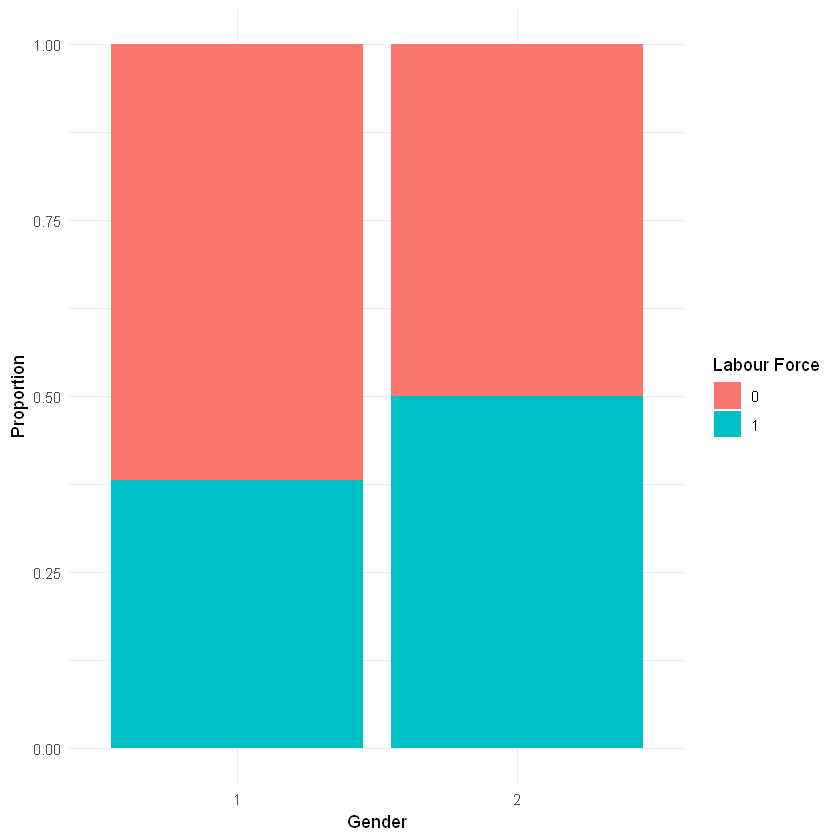

In [7]:
ggplot(data_clean, aes(x = Gender, fill = factor(labour_force))) +
  geom_bar(position = "fill") +  
  labs(y = "Proportion", fill = "Labour Force") +
  theme_minimal()

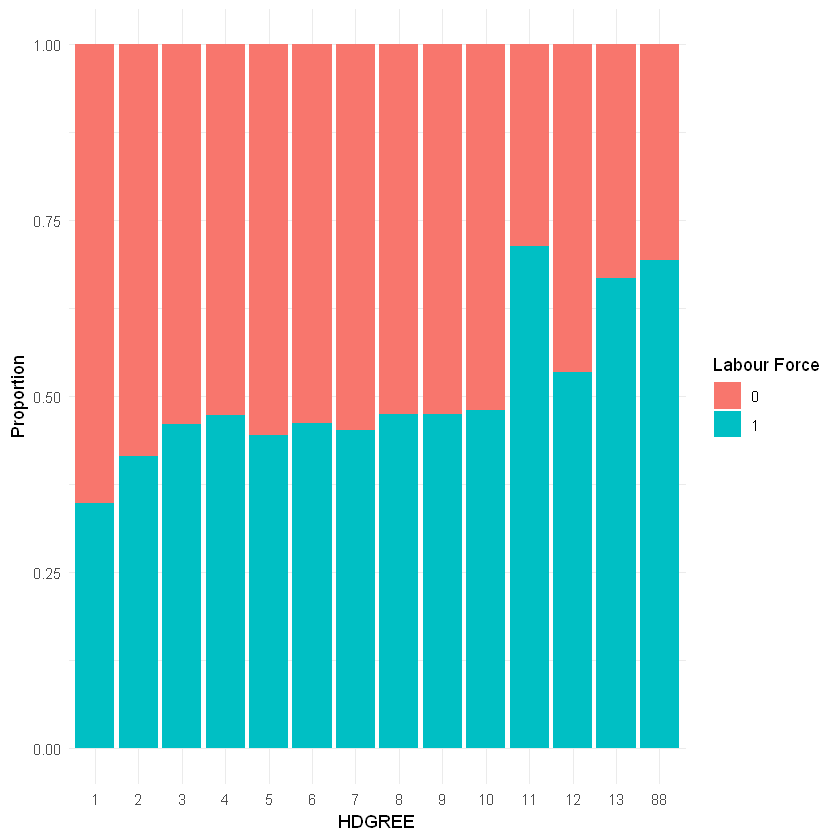

In [8]:
ggplot(data_clean, aes(x = HDGREE, fill = factor(labour_force))) +
  geom_bar(position = "fill") +
  labs(y = "Proportion", fill = "Labour Force") +
  theme_minimal()


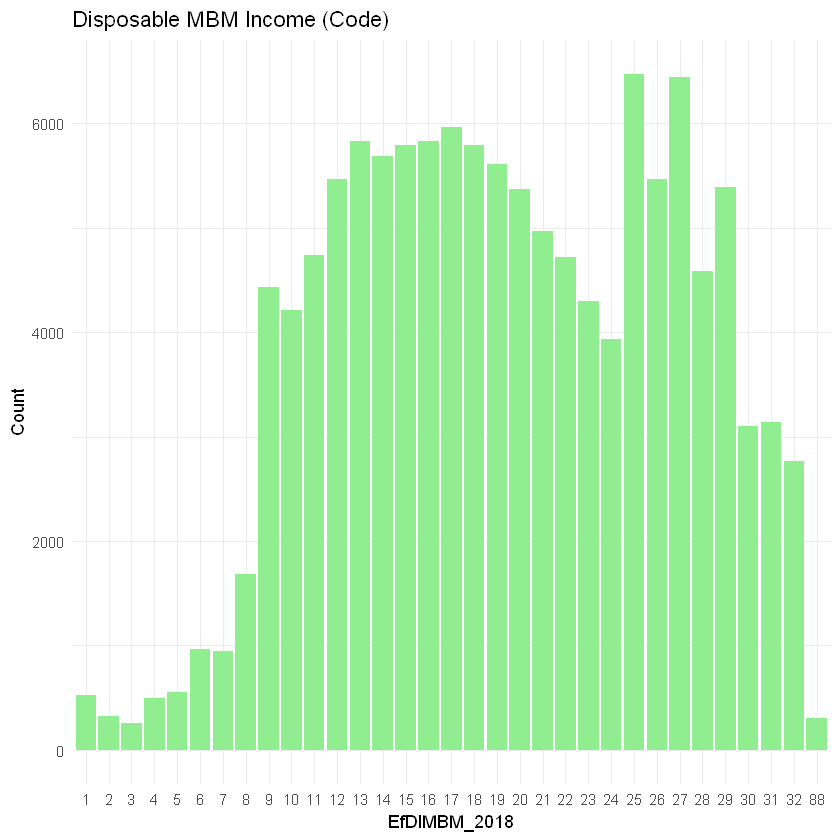

In [9]:
ggplot(data_clean, aes(x = EfDIMBM_2018)) +
  geom_bar(fill = "lightgreen") +
  labs(title = "Disposable MBM Income (Code)", x = "EfDIMBM_2018", y = "Count") +
  theme_minimal()

# modeling

In [10]:
model_dd_glm <- glm(
  labour_force ~ post * treat + Gender + HDGREE + HHInc_AT, #remove EfDIMBM_2018 
  data = data_clean,
  family = binomial
)

summary(model_dd_glm)


Call:
glm(formula = labour_force ~ post * treat + Gender + HDGREE + 
    HHInc_AT, family = binomial, data = data_clean)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.12027    0.08445 -13.265  < 2e-16 ***
post        -1.05978    0.02237 -47.374  < 2e-16 ***
treat        0.27722    0.02356  11.768  < 2e-16 ***
Gender2      0.50953    0.01259  40.469  < 2e-16 ***
HDGREE2      0.25552    0.01945  13.138  < 2e-16 ***
HDGREE3      0.40557    0.03033  13.374  < 2e-16 ***
HDGREE4      0.28113    0.03240   8.677  < 2e-16 ***
HDGREE5      0.39811    0.03514  11.329  < 2e-16 ***
HDGREE6      0.40389    0.02565  15.744  < 2e-16 ***
HDGREE7      0.28070    0.02813   9.980  < 2e-16 ***
HDGREE8      0.43667    0.03836  11.384  < 2e-16 ***
HDGREE9      0.31825    0.02328  13.672  < 2e-16 ***
HDGREE10     0.36070    0.05227   6.901 5.17e-12 ***
HDGREE11     1.16089    0.08499  13.659  < 2e-16 ***
HDGREE12     0.50186    0.03326  15.087  < 2e-16 ***
HDGREE13     0.

In [11]:
library(stargazer)


Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.



 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 




In [12]:
stargazer(model_dd_glm, 
          type = "html", 
          title = "Regression Results: DID Model", 
          align = TRUE, 
          digits = 2, 
          out = "regression_results.html")


<table style="text-align:center"><caption><strong>Regression Results: DID Model</strong></caption>
<tr><td colspan="2" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td><em>Dependent variable:</em></td></tr>
<tr><td></td><td colspan="1" style="border-bottom: 1px solid black"></td></tr>
<tr><td style="text-align:left"></td><td>labour_force</td></tr>
<tr><td colspan="2" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">post</td><td>-1.06<sup>***</sup></td></tr>
<tr><td style="text-align:left"></td><td>(0.02)</td></tr>
<tr><td style="text-align:left"></td><td></td></tr>
<tr><td style="text-align:left">treat</td><td>0.28<sup>***</sup></td></tr>
<tr><td style="text-align:left"></td><td>(0.02)</td></tr>
<tr><td style="text-align:left"></td><td></td></tr>
<tr><td style="text-align:left">Gender2</td><td>0.51<sup>***</sup></td></tr>
<tr><td style="text-align:left"></td><td>(0.01)</td></tr>
<tr><td style="text-align:left"></

# visualization

## common trend

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


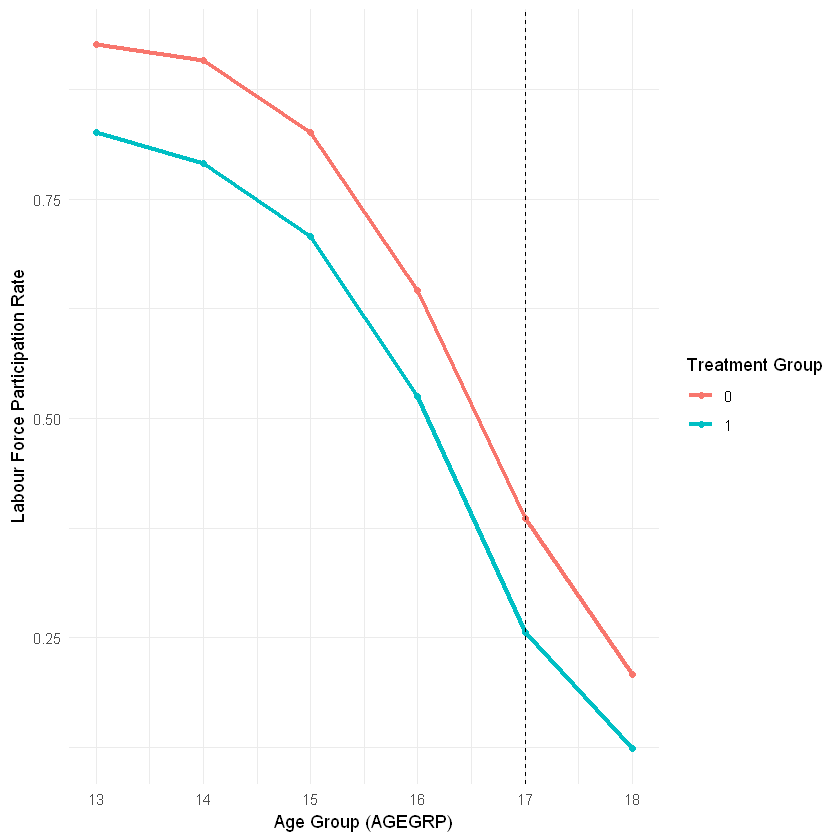

In [13]:
pre_data <- data %>%
  filter(AGEGRP %in% c(13,14,15,16,17,18)) %>%
  mutate(
    labour_force = ifelse(LFACT %in% 1:10, 1, 0),
    treat = case_when(
      IMMSTAT == 1 & HHInc_AT %in% 1:22 ~ 1,      
      IMMSTAT == 1 & HHInc_AT >= 23 ~ 0,
      IMMSTAT == 2 & AGEIMM <= 11 ~ 1,
      IMMSTAT == 2 & AGEIMM > 11 ~ 0,
      IMMSTAT == 3 ~ NA_real_,
      AGEIMM %in% c(88, 99) ~ NA_real_
    )
  ) %>%
  filter(IMMSTAT %in% c(1,2), !is.na(treat), !is.na(labour_force)) %>%
  group_by(AGEGRP, treat) %>%
  summarise(lfp_rate = mean(labour_force), .groups = "drop")

# plot
library(ggplot2)

ggplot(pre_data, aes(x = AGEGRP, y = lfp_rate, color = factor(treat))) +
  geom_line(size = 1.2) +
  geom_point() +
  geom_vline(xintercept = 17, linetype = "dashed", color = "black") +
  labs(
    x = "Age Group (AGEGRP)",
    y = "Labour Force Participation Rate",
    color = "Treatment Group"
  ) +
  theme_minimal()


# post bar

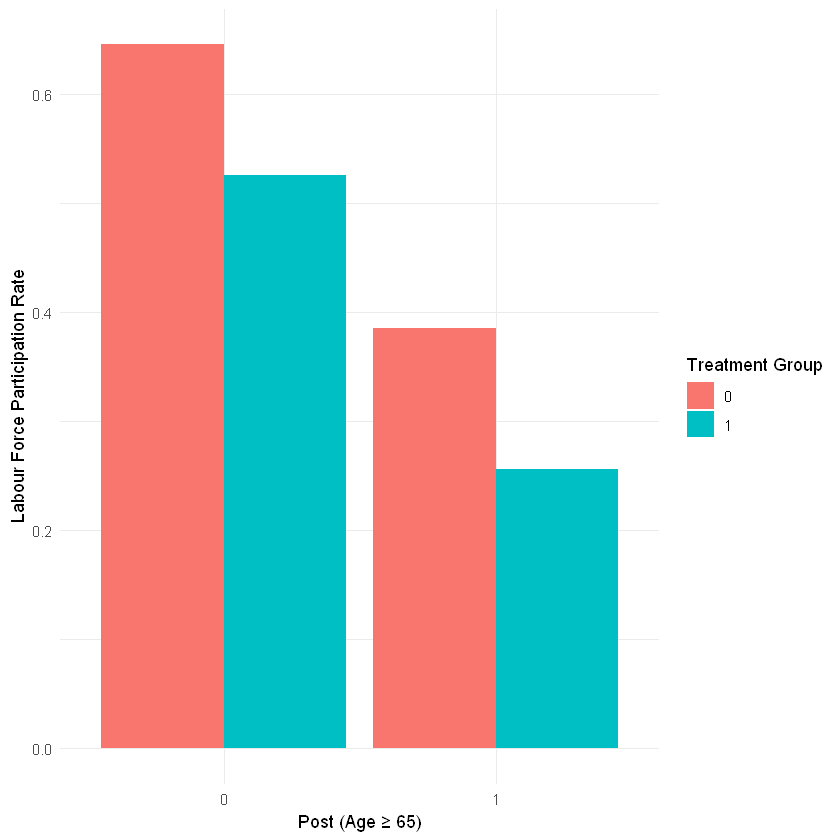

In [14]:
ggplot(data_clean, aes(x = factor(post), y = labour_force, fill = factor(treat))) +
  stat_summary(fun = mean, geom = "bar", position = "dodge") +
  labs(
    x = "Post (Age ≥ 65)",
    y = "Labour Force Participation Rate",
    fill = "Treatment Group"
  ) +
  theme_minimal()
